In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from create_data import DataCreator
from lstm import LSTMRegressor, train_loop
from sklearn import set_config
from torchinfo import summary

set_config(transform_output = "pandas")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


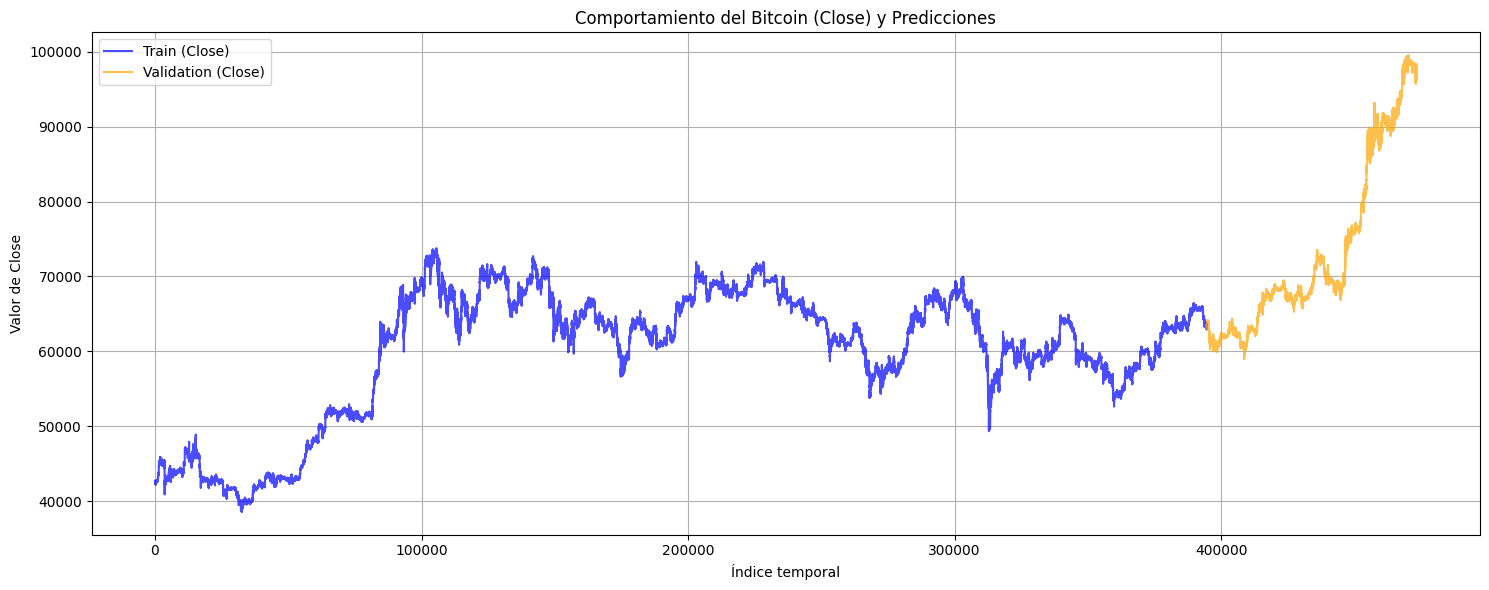

In [3]:
path = "Binance_BTCUSDT_2024_minute.csv"
date_cols = ["Date"]
cols_to_drop = ["Unix","Symbol","Volume BTC","Volume USDT"]

data = DataCreator(path = path, date_cols = date_cols, cols_to_drop = cols_to_drop)
train_sequences, val_sequences = data.run(month = 9, seq_len = 120, tc = "Close")

data.plot_split_data()


In [4]:
x = torch.randint(1, 100, (1, 120, 11), dtype = torch.float)
lstm = LSTMRegressor(input_size = 11, hidden_size = 2, n_layers = 2)

output = lstm(x)

# Mostrar el resultado
print("Salida del modelo:", output)
print("Forma de la salida:", output.shape)

Salida del modelo: tensor([[-0.2814]], grad_fn=<AddmmBackward0>)
Forma de la salida: torch.Size([1, 1])


In [5]:
summary(lstm, input_size = (1, 120, 11))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMRegressor                            [1, 1]                    --
├─LSTM: 1-1                              [1, 120, 2]               168
├─Linear: 1-2                            [1, 1]                    3
Total params: 171
Trainable params: 171
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [6]:
model = LSTMRegressor(input_size = 11, hidden_size = 2, n_layers = 2)

training_params = {"num_epochs": 10, "learning_rate": 3e-4, "batch_size": 100}

model, train_losses, val_losses = train_loop(model, train_seq = train_sequences, val_seq = val_sequences, training_params = training_params)

Epoch: 1- Time:  9.02 - Train L1 Loss:  0.0632 - Validation L1 Loss: 0.2748 - Train RMSE: 0.0879 - Validation RMSE: 0.4017
Epoch: 2- Time:  8.87 - Train L1 Loss:  0.0514 - Validation L1 Loss: 0.2749 - Train RMSE: 0.0843 - Validation RMSE: 0.4023
Epoch: 3- Time:  9.57 - Train L1 Loss:  0.0415 - Validation L1 Loss: 0.2747 - Train RMSE: 0.0767 - Validation RMSE: 0.4028
Epoch: 4- Time:  9.52 - Train L1 Loss:  0.0350 - Validation L1 Loss: 0.2733 - Train RMSE: 0.0705 - Validation RMSE: 0.4030
Epoch: 5- Time:  8.64 - Train L1 Loss:  0.0297 - Validation L1 Loss: 0.2708 - Train RMSE: 0.0657 - Validation RMSE: 0.4027
Epoch: 6- Time:  8.29 - Train L1 Loss:  0.0256 - Validation L1 Loss: 0.2673 - Train RMSE: 0.0618 - Validation RMSE: 0.4019
Epoch: 7- Time:  8.28 - Train L1 Loss:  0.0221 - Validation L1 Loss: 0.2602 - Train RMSE: 0.0584 - Validation RMSE: 0.4002
Epoch: 8- Time:  8.59 - Train L1 Loss:  0.0194 - Validation L1 Loss: 0.2527 - Train RMSE: 0.0556 - Validation RMSE: 0.3978
Epoch: 9- Time: 

In [7]:
train_seq = [seq[0] for seq in train_sequences]  # Obtener las secuencias (X)
train_seq = np.array(train_seq)  # Convertir a array de NumPy
train_seq = torch.tensor(train_seq, dtype = torch.float32)  # Convertir a tensor de PyTorch

test_seq = [seq[0] for seq in val_sequences]
test_seq = np.array(test_seq)
test_seq = torch.tensor(test_seq, dtype = torch.float32)

model.to("cpu")
model.eval()

# Realizar predicción en lote
with torch.no_grad():
    train_preds = model(train_seq)  # Pasar todo el tensor al modelo de una sola vez
    test_preds = model(test_seq)

train_preds = data.inverse_scale(train_preds)
test_preds = data.inverse_scale(test_preds)


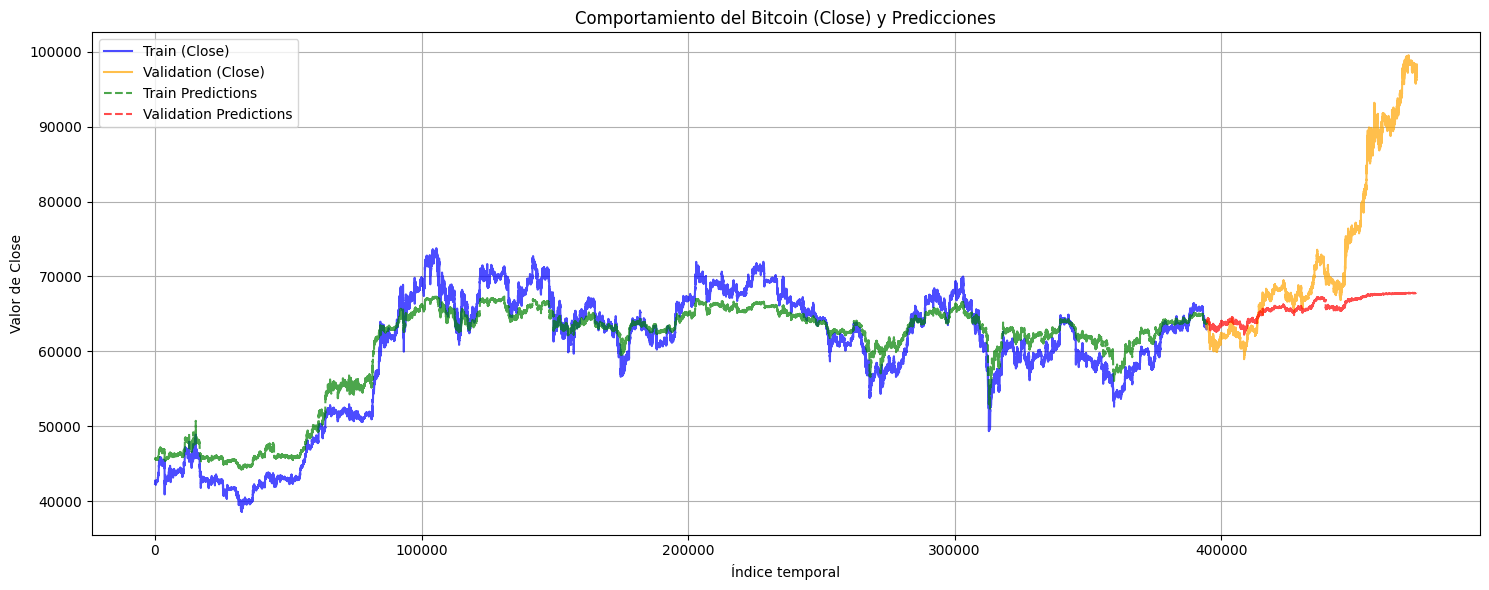

In [8]:
data.plot_split_data(train_preds = train_preds, test_preds = test_preds)